In [1]:
include("includes.jl");

### The setup

### Plotting the likelihood

Interact.Options{:SelectionSlider,Any}(17: "input-7" = 6 Any , "n", 6, "6", 6, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(2, "2"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(7, "7"),Pair{Any,Any}(9, "9"),Pair{Any,Any}(10, "10"),Pair{Any,Any}(8, "8"),Pair{Any,Any}(6, "6"),Pair{Any,Any}(4, "4"),Pair{Any,Any}(3, "3"),Pair{Any,Any}(5, "5")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(19: "input-8" = 29 Any , "kid", 29, "29", 29, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(2, "2"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(46, "46"),Pair{Any,Any}(25, "25"),Pair{Any,Any}(55, "55"),Pair{Any,Any}(42, "42"),Pair{Any,Any}(29, "29"),Pair{Any,Any}(58, "58"),Pair{Any,Any}(8, "8")…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Any}(21: "input-9" = 5 Any , "t0", 5, "5", 5, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(7, "7"),Pair{Any,Any}(4, "4"),Pair{Any,Any}(9, "9"),Pair{Any,Any}(10, "10"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(3, "3"),Pair{Any,Any}(5, "5"),Pair{Any,Any}(8, "8"),Pair{Any,Any}(6, "6"),Pair{Any,Any}(1, "1")…)), Any[], Any[], true, "horizontal")

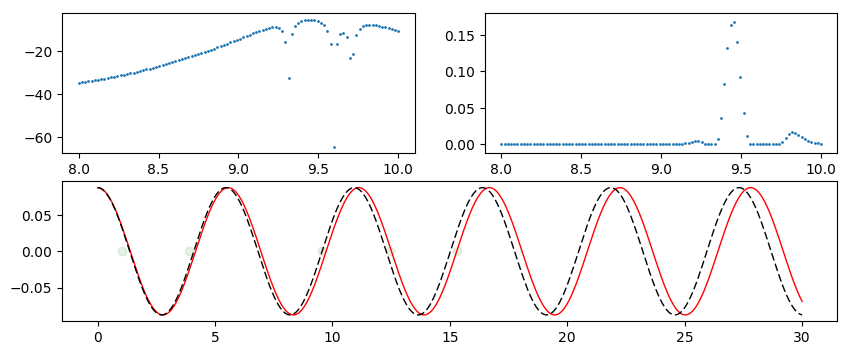

In [4]:
using Interact

measurements, measurements_mask = load_experiments()
n_measurements = size(measurements)[1]
max_intersects = size(measurements)[2]

PyPlot.rc("figure", figsize=(10,4))
fig = figure()

prior = Uniform(8,11)

evaluation_mesh=collect(0:0.01:30)

#Θ₀ = [5*pi/180, 0]
function dΘ(g)
    Θ -> [Θ[2], -g*sin(Θ[1])/7.4]
end

loglikelihood = (k, n, Θ₀, g) ->
    let
        Gg = rk4s(dΘ(g), Θ₀, [0; measurements[k,1:n][measurements_mask[k,1:n] .!= 0]], 0.01) 
        b = log.(abs.(0.01 ./ (0.01 + Gg[2:end,1]))).^2
        sum(b)/0.5
    end;


mesh = linspace(8,10,100)

@manipulate for n = 1:max_intersects, kid=1:n_measurements, t0=1:10
    
    
    Θ₀ = [t0*pi/180, 0]
    
    lhood = -(g -> loglikelihood(kid,n,Θ₀,g)).(mesh)
    elhood = exp.(lhood)
    elhood = elhood / sum(elhood)
    
    mle = mesh[findmax(lhood)[2]]
    
    Gg_ref = rk4s(dΘ(9.8), Θ₀, evaluation_mesh, 0.01)[:,1]
    Gg_mle = rk4s(dΘ(mle), Θ₀, evaluation_mesh, 0.01)[:,1]
    
    withfig(fig) do
        subplot(2,2,1)
        scatter(mesh, lhood,s=1)
        subplot(2,2,2)
        scatter(mesh, elhood,s=1)
        subplot(2,1,2)
       
        plot(evaluation_mesh,Gg_mle,c="red",linewidth=1)
        plot(evaluation_mesh,Gg_ref,c="black",linestyle="--", linewidth=1)
        
        mm = measurements[kid,1:n][measurements_mask[kid,1:n] .!= 0]
        scatter(mm, zeros(mm), c="green",marker="o",alpha=0.1) 
    end
end

### MCMC implementation for gaussian error

In [14]:
function GaussianMetropolisHastings(K, prior, ϕ, γ)
    x₀ = rand(prior, 1)
    
    X = zeros(K, length(x₀))
    Y = zeros(K, length(x₀))
    W = zeros(K)
    accepted = 0
    
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    ϕₓ = ϕ(x)
    
    for k=1:K
        y = x + rand(w)
        ϕₙ = ϕ(y)
        if rand() < min(1, (pdf(prior, y[1])/pdf(prior, x[1]))*exp(ϕₓ-ϕₙ))
            x = y
            ϕₓ = ϕₙ
            accepted += 1
        end
        
        W[k] = ϕₙ
        Y[k,:] = y
        X[k,:] = x
    end
    X, Y, exp.(-W), accepted
end

GaussianMetropolisHastings (generic function with 1 method)

### MCMC run

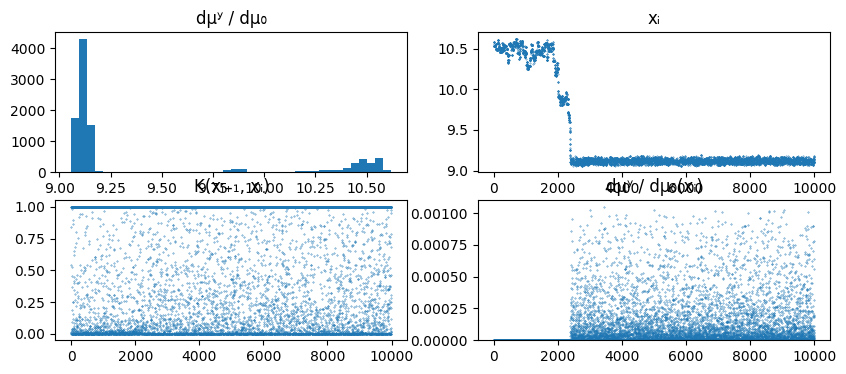

2726 / 10000 of the sampled particles were accepted (27.0%)
        
The expectation estimation is of 9.413542640876058


In [64]:

out = GaussianMetropolisHastings(10000, prior, g -> loglikelihood(1, 11, g[1]), 0.05)
plotMCMC(out)

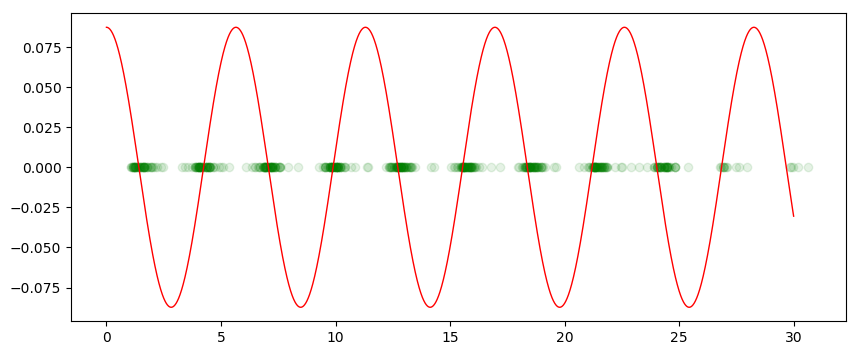

PyObject <matplotlib.collections.PathCollection object at 0x7fc03e5a3650>

In [66]:
flat_measurements = load_flat_data()
evaluation_mesh=collect(0:0.01:30)

Θ₀ = [5*pi/180, 0]
function dΘ(g)
    Θ -> [Θ[2], -g*sin(Θ[1])/7.4]
end

Gg = rk4s(dΘ(mean(out[1][2000:end])), Θ₀, evaluation_mesh, 0.01)[:,1]
plot(evaluation_mesh,Gg,c="red",linewidth=1)

scatter(flat_measurements, zeros(flat_measurements), c="green",marker="o",alpha=0.1) 

In [23]:
# Posterior Predictive Check
# posterior_intersections = (g -> simulate(max_intersects, g)).(outt[1])
mean_posterior_intersections = mean(hcat(posterior_intersections...),2)'
mean_data_intersections = sum(measurements,1) ./ sum(measurements_mask,1)

plot(evaluation_mesh,Gg,c="red",linewidth=1,linestyle="--")
scatter(flat_measurements, zeros(flat_measurements), c="green",marker="o",alpha=0.1) 
for i=1:length(mean_intersections)
   plot([mean_intersections[i]; mean_intersections[i]], [-0.01;0.01],c="black",linestyle="--")
   plot([mean_data_intersections[i]; mean_data_intersections[i]], [-0.01;0.01],c="green")
end

vecnorm(mean_data_intersections - mean_posterior_intersections)

LoadError: [91mUndefVarError: posterior_intersections not defined[39m